## Calculating likelihoods

In [1]:
import matplotlib.pyplot as plt
import corner as corner
import pandas as pd
import numpy as np
import h5py
import torch

from populations.bbh_models import get_models
import populations.bbh_models as read_models
from populations.utils.flow import NFlow
from populations.Flowsclass_dev import FlowModel
from populations import gw_obs

glasflow is using its own internal version of nflows


PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


In [2]:
#reading the pop synth file functions
def get_model_keys(path):
    alpha_val = '10'
    all_models = []
    models = []
    def find_submodels(name, obj):
        if isinstance(obj, h5py.Dataset):
            all_models.append(name.rsplit('/', 1)[0])
            
    f = h5py.File(path, 'r')
    f.visititems(find_submodels)
    # get all unique models
    all_models = sorted(list(set(all_models)))
    f.close()

    # use only models with given alpha value
    for model in all_models:
        if 'alpha' in model:
            if 'alpha'+alpha_val in model:
                models.append('/'+model)
        else:
            models.append('/' + model)
    return(np.split(np.array(models), 5))

def get_model_keys_CE(path):
    all_models = []
    models = []
    def find_submodels(name, obj):
        if isinstance(obj, h5py.Dataset):
            all_models.append(name.rsplit('/', 1)[0])
            
    f = h5py.File(path, 'r')
    f.visititems(find_submodels)
    # get all unique models
    all_models = sorted(list(set(all_models)))
    return(np.split(np.array(models), 4))

def read_hdf5(path, all_alpha=False):
    if all_alpha:
        popsynth_outputs = {}
        models = np.asarray(get_model_keys_CE(path))
        for i in range(models.shape[0]):
            for j in range(models.shape[1]):
                popsynth_outputs[i,j]=pd.read_hdf(path, key=models[i,j])
    else:
        popsynth_outputs = {}
        models = np.asarray(get_model_keys(path))
        for i in range(models.shape[0]):
            for j in range(models.shape[1]):
                popsynth_outputs[i,j]=pd.read_hdf(path, key=models[i,j])

    return(popsynth_outputs)

In [3]:

params = ['mchirp','q', 'chieff', 'z']
param_bounds = np.array([[0,100], [0,1], [-1,1], [0,10]])
obs = np.random.rand(100,46,4)
obs[:,:,0] *=param_bounds[0,1]
obs[:,:,1] *=param_bounds[1,1]
obs[:,:,2] -= 0.5
obs[:,:,2] *=param_bounds[2,1]*2
obs[:,:,3] *=param_bounds[3,1]

In [4]:
file_path='/Users/stormcolloms/Documents/PhD/Project_work/OneChannel_Flows/models_reduced.hdf5'
gw_path = '/Users/stormcolloms/Documents/PhD/Project_work/AMAZE_model_selection/gw_events'
observations, obsdata, p_theta, events = gw_obs.generate_observations(params, gw_path, \
                                            100, 'posteriors', None)

popsynth_outputs = read_hdf5(file_path, True)
flow = FlowModel.from_samples('CE', popsynth_outputs, params)
flow.load_model('/Users/stormcolloms/Documents/PhD/Project_work/AMAZE_model_selection/flow_models/', 'CE')

/Users/stormcolloms/opt/anaconda3/envs/amaze/lib/python3.9/site-packages/arviz/data/base.py:221: UserWarning: More chains (100) than draws (46). Passed array should have shape (chains, draws, *shape)
  warnings.warn(


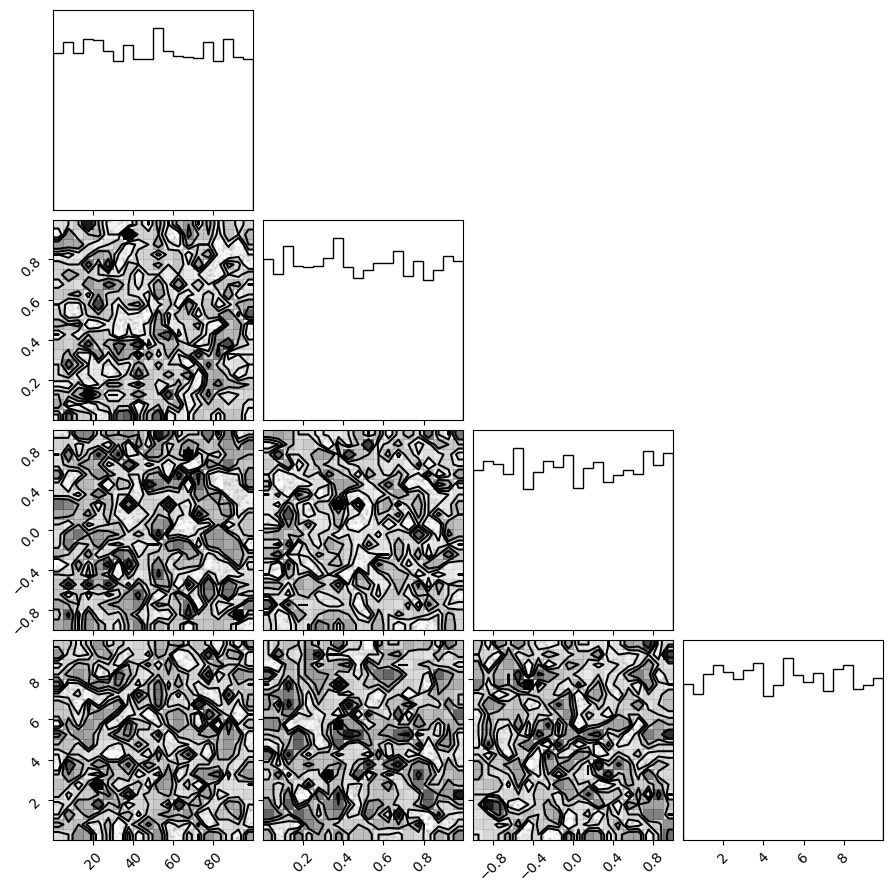

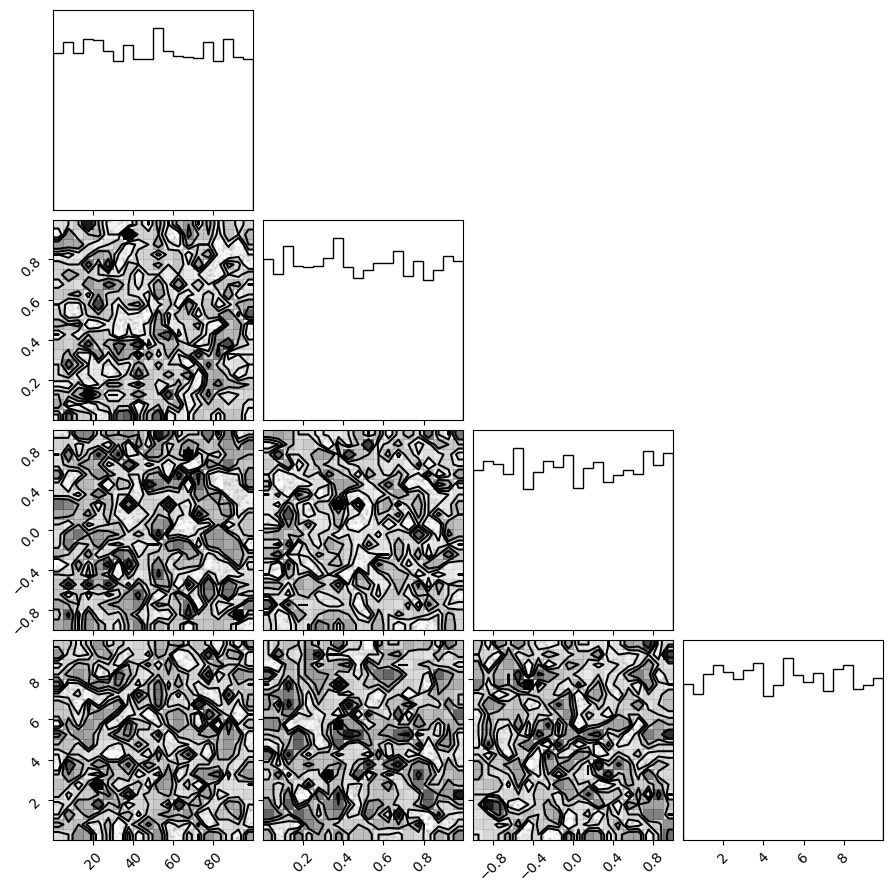

In [5]:
#check the mock observations
corner.corner(obs)

In [6]:
likelihoods = flow(obs,[3,1])

(100, 46)


In [7]:
print(likelihoods)

51.057844187596906
